# Deteksi Penyakit Otak Menggunakan CNN dan Image Preprocessing

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
from keras import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Input, Dropout
from sklearn.metrics import accuracy_score
from tkinter import Tk, filedialog

In [2]:
# **1. Load Dataset dengan Normalisasi dan Label Checking**
def load_data(directory):
    dataset = tf.keras.preprocessing.image_dataset_from_directory(
        directory, image_size=(400, 600), color_mode='grayscale', shuffle=True
    )
    
    class_names = dataset.class_names
    print("Class names in dataset:", class_names)  # Cek apakah urutan label sesuai
    
    x, y = [], []
    for images, labels in dataset:
        x.extend(images.numpy())
        y.extend(labels.numpy())
    
    x = np.array(x) / 255.0  # Normalisasi data
    y = np.array(y)
    return tf.convert_to_tensor(x), tf.convert_to_tensor(y), class_names

In [3]:
train_dir = 'healthy/data_train'
test_dir = 'healthy/data_test'

x_train, y_train, class_names = load_data(train_dir)
x_test, y_test, _ = load_data(test_dir)

Found 253 files belonging to 3 classes.
Class names in dataset: ['CTBrain_aneurysm', 'CTBrain_cancer', 'CTBrain_tumor']
Found 3 files belonging to 3 classes.
Class names in dataset: ['CTBrain_aneurysm', 'CTBrain_cancer', 'CTBrain_tumor']


In [4]:
# **2. Data Augmentation yang Lebih Baik**
trainDataGen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True
)

trainGenerator = trainDataGen.flow_from_directory(
    train_dir,
    target_size=(400, 600),
    color_mode='grayscale'
)

Found 253 images belonging to 3 classes.


In [5]:
# **3. Define CNN Model dengan Dropout**
tensor_list = np.array(y_train)
output_dim = len(set(tensor_list.tolist()))
input_shape = x_train.shape[1:]

model = Sequential([
    Input(shape=input_shape),
    Conv2D(6, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(12, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(24, (3, 3), activation='relu'),
    Flatten(),
    Dropout(0.3),  # Mengurangi overfitting
    Dense(output_dim, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [6]:
# **4. Train Model**
history = model.fit(x_train, y_train, epochs=20, verbose=1)

Epoch 1/20
8/8 [==============================] - 7s 801ms/step - loss: 0.6339 - accuracy: 0.7787
Epoch 2/20
8/8 [==============================] - 7s 836ms/step - loss: 0.1450 - accuracy: 0.9526
Epoch 3/20
8/8 [==============================] - 7s 898ms/step - loss: 0.0584 - accuracy: 0.9763
Epoch 4/20
8/8 [==============================] - 7s 865ms/step - loss: 0.0740 - accuracy: 0.9802
Epoch 5/20
8/8 [==============================] - 6s 751ms/step - loss: 0.0293 - accuracy: 0.9842
Epoch 6/20
8/8 [==============================] - 6s 768ms/step - loss: 0.0317 - accuracy: 0.9763
Epoch 7/20
8/8 [==============================] - 6s 809ms/step - loss: 0.0204 - accuracy: 0.9921
Epoch 8/20
8/8 [==============================] - 7s 856ms/step - loss: 0.0345 - accuracy: 0.9802
Epoch 9/20
8/8 [==============================] - 7s 851ms/step - loss: 0.0311 - accuracy: 0.9921
Epoch 10/20
8/8 [==============================] - 7s 809ms/step - loss: 0.0324 - accuracy: 0.9921
Epoch 11/20
8/8 [==

In [7]:
# **5. Evaluate Model**
pred_train = model.predict(x_train, verbose=0).argmax(axis=1)
pred_test = model.predict(x_test, verbose=0).argmax(axis=1)
print("Training Accuracy:", accuracy_score(y_train, pred_train))
print("Testing Accuracy:", accuracy_score(y_test, pred_test))

Training Accuracy: 0.9920948616600791
Testing Accuracy: 1.0


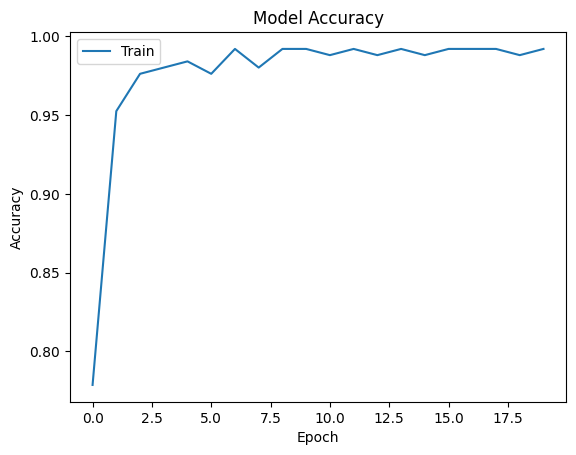

In [8]:
# **6. Plot Training History**
plt.plot(history.history['accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train'], loc='upper left')
plt.show()

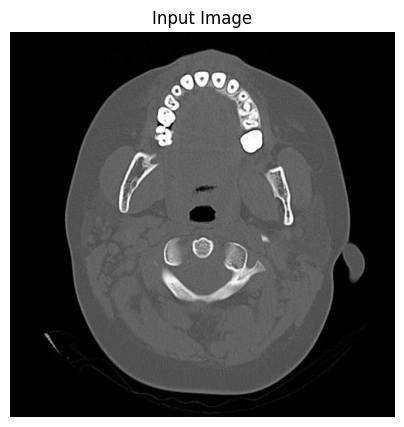

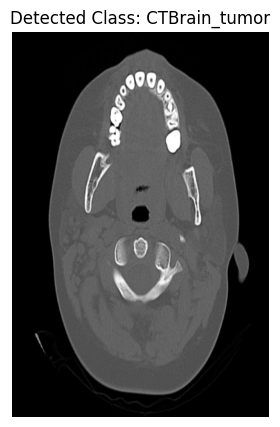

Detected Class: CTBrain_tumor


In [13]:
# **7. Testing on New Data dengan Tampilan Gambar Input dan Hasil Prediksi**
def select_image():
    root = Tk()
    root.withdraw()
    file_path = filedialog.askopenfilename(filetypes=[("Image Files", "*.png;*.jpg;*.jpeg")])
    return file_path

image_path = select_image()
if image_path:
    # Baca dan tampilkan gambar asli
    sample_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    plt.figure(figsize=(5, 5))
    plt.imshow(sample_image, cmap='gray')
    plt.title("Input Image")
    plt.axis("off")
    plt.show()

    # Pastikan ukuran sesuai dengan model
    sample_image = cv2.resize(sample_image, (400, 600))  
    sample_image = np.expand_dims(sample_image, axis=-1)  # Tambah channel
    sample_image = np.expand_dims(sample_image, axis=0)   # Tambah batch dimensi
    sample_image = sample_image / 255.0  # Normalisasi

    # Prediksi kelas gambar
    prediction = model.predict(sample_image, verbose=0).argmax()
    detected_class = class_names[prediction]
    
    plt.figure(figsize=(5, 5))
    plt.imshow(sample_image[0, :, :, 0], cmap='gray')
    plt.title(f"Detected Class: {detected_class}")
    plt.axis("off")
    plt.show()
    
    print(f"Detected Class: {detected_class}")
else:
    print("No image selected.")
